In [150]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric
import seaborn as sns
from sklearn.model_selection import train_test_split

In [151]:
#import dataset
df_complete = pd.read_excel('EA_GDP.xlsx')
df_complete.head()


,TIME,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1991Q1,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1991Q2,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1991Q3,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1991Q4,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1992Q1,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [115]:
df = df_complete.drop('TIME', axis=1)
df.head()

,RGDP,CISS,GDPlog,GDPgrowth(annualized),GDPgrowth/400
0,1.851747e+06,0.121591,14.431640,0.026317,0.000066
1,1.856938e+06,0.061375,14.434440,0.024727,0.000062
2,1.857512e+06,0.057187,14.434749,0.015219,0.000038
3,1.876601e+06,0.081339,14.444973,0.019042,0.000048
4,1.902687e+06,0.080447,14.458777,0.027137,0.000068


In [117]:
rgdp = df['RGDP'].values.astype(float) 
ciss = df['CISS'].values.astype(float) 
rgdp_an = df['GDPgrowth(annualized)'].values.astype(float) 
rgdp_growth = df['GDPgrowth/400'].values.astype(float) 

rgdp_lag = np.roll(rgdp_an, 1)
rgdp_lag[0] = 0
rgdp_lag_growth = np.roll(rgdp_growth, 1)
rgdp_lag_growth[0] = 0

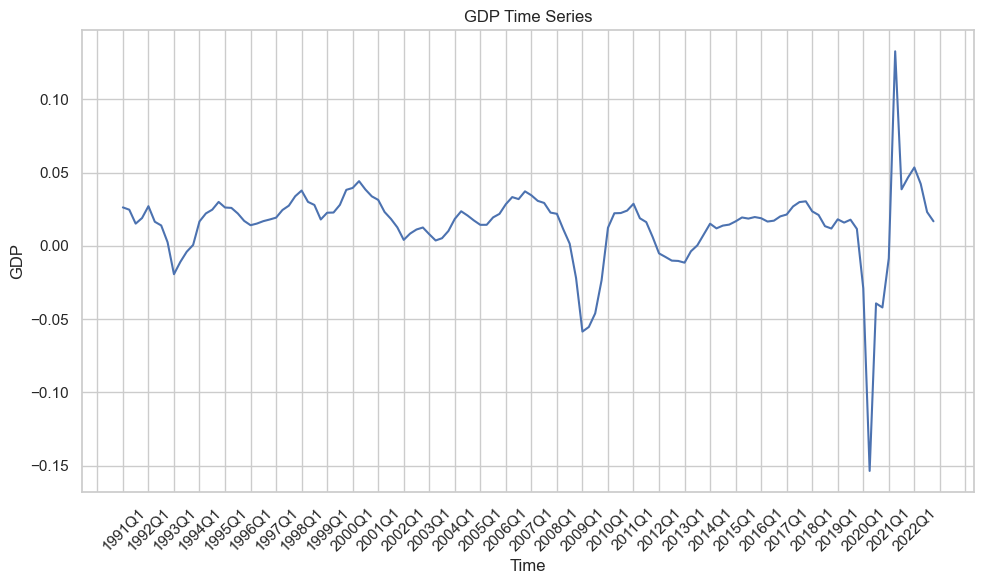

In [118]:
#Time Series Plot
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_complete, x='TIME', y='GDPgrowth(annualized)', ax=ax)
locator = MultipleLocator(base=4)
ax.xaxis.set_major_locator(locator)

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('GDP')
ax.set_title('GDP Time Series')
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()


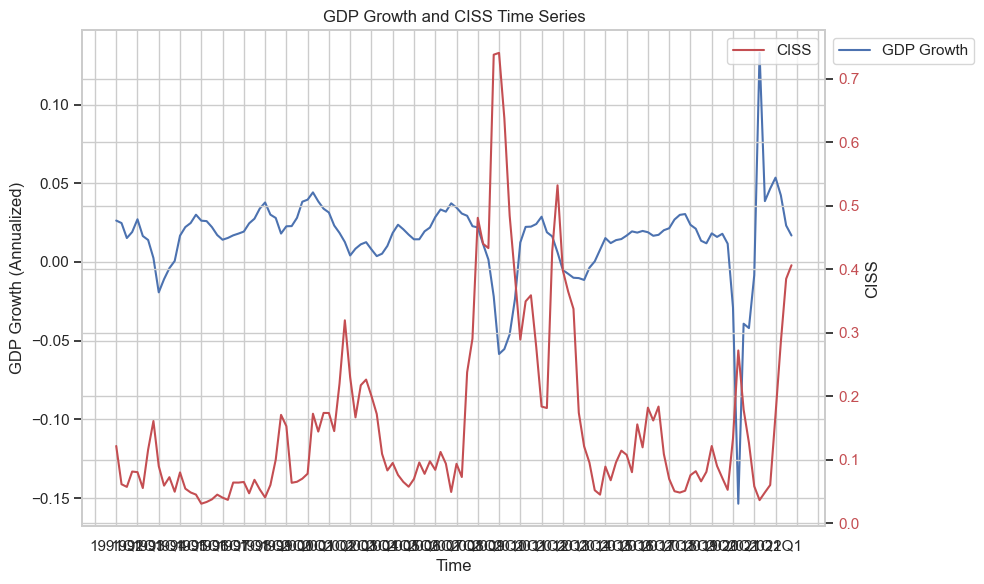

In [58]:

sns.set(style='whitegrid')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the GDP time series
sns.lineplot(data=df, x='TIME', y='GDPgrowth(annualized)', ax=ax, label='GDP Growth')

# Set labels and title for GDP
ax.set_xlabel('Time')
ax.set_ylabel('GDP Growth (Annualized)')
ax.set_title('GDP Growth and CISS Time Series')

# Create a secondary y-axis for CISS
ax2 = ax.twinx()

# Plot the CISS time series
sns.lineplot(data=df, x='TIME', y='CISS', ax=ax2, color='r', label='CISS')

# Set labels and title for CISS
ax2.set_ylabel('CISS')
ax2.tick_params(axis='y', labelcolor='r')

# Remove x-axis labels and ticks from secondary y-axis
ax2.set_xticks([])

# Set locator for x-axis labels
locator = MultipleLocator(base=4)
ax.xaxis.set_major_locator(locator)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Display legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout
fig.tight_layout()

# Display the plot
plt.show()


In [10]:
''' QL regression with package'''
X = np.column_stack((np.ones_like(rgdp_an), rgdp_lag, ciss))

# Use the standardized variables in the regression analysis
quant_reg_1 = sm.QuantReg(rgdp_an, X).fit(q=0.1)
quant_reg_5 = sm.QuantReg(rgdp_an, X).fit(q=0.5)
quant_reg_9 = sm.QuantReg(rgdp_an, X).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary()) 



                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.4648
Model:                       QuantReg   Bandwidth:                    0.004994
Method:                 Least Squares   Sparsity:                      0.03425
Date:                Fri, 16 Jun 2023   No. Observations:                  128
Time:                        13:52:08   Df Residuals:                      125
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.472      0.638      -0.003       0.004
x1             0.8133      0.052     15.634      0.000       0.710       0.916
x2            -0.0325      0.008     -4.157      0.000      -0.048      -0.017
                         QuantReg Regression Results

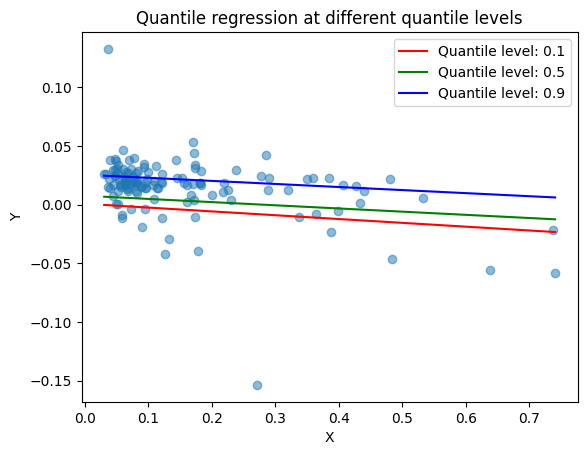

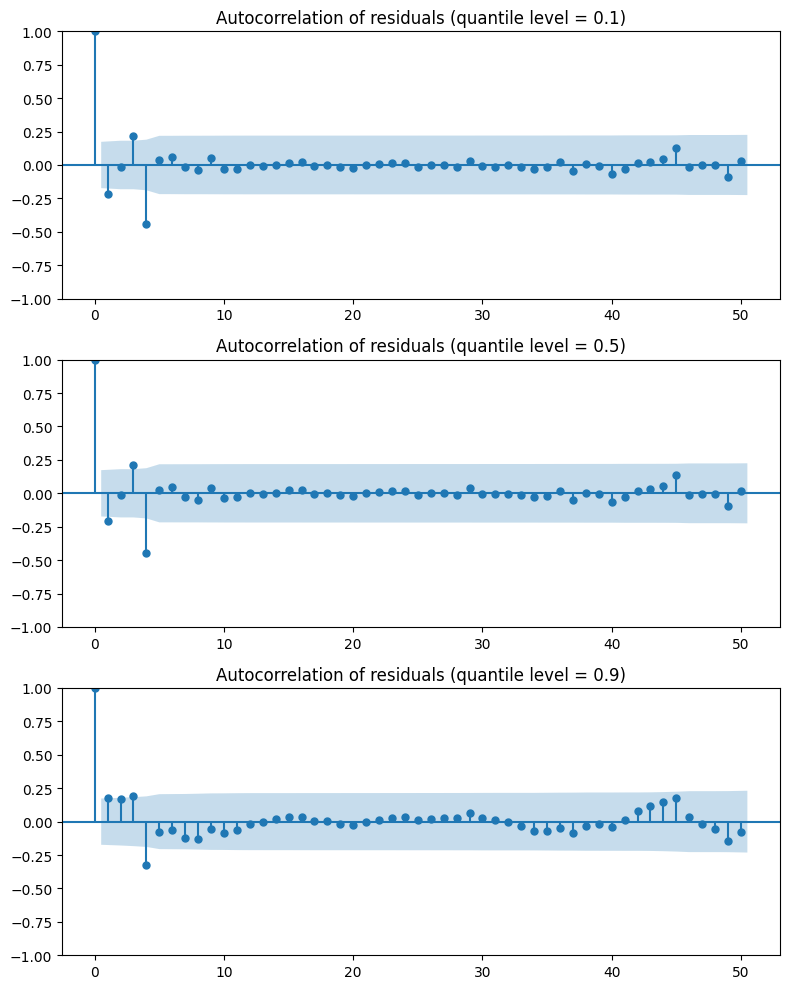

In [23]:
################################ Quantile regression plot ##############################
fig, ax = plt.subplots()
ax.scatter(ciss, rgdp_an, alpha=0.5)

    # Generate x values for the regression lines
x_vals = np.linspace(np.min(ciss), np.max(ciss), 100)
y_vals_lag = np.linspace(np.min(rgdp_lag), np.max(rgdp_lag), 100)
    # Plot the regression lines
ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Quantile regression at different quantile levels')
plt.show()

################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, lags=50, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, lags=50, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Perform Ljung-Box test with up to 10 lags
lbtest = acorr_ljungbox(residuals_1, lags=50)

# Print p-values for each lag
print(lbtest)

      lb_stat     lb_pvalue
1    6.367790  1.162103e-02
2    6.409466  4.056973e-02
3   12.858613  4.952557e-03
4   39.111716  6.605936e-08
5   39.275740  2.089869e-07
6   39.774218  5.044979e-07
7   39.795657  1.377365e-06
8   40.018515  3.178378e-06
9   40.357593  6.544687e-06
10  40.512653  1.376055e-05
11  40.640925  2.778095e-05
12  40.641736  5.623738e-05
13  40.646325  1.087236e-04
14  40.647177  2.020846e-04
15  40.696604  3.556747e-04
16  40.750632  6.043200e-04
17  40.765981  1.007977e-03
18  40.767175  1.639054e-03
19  40.803225  2.563315e-03
20  40.872907  3.867740e-03
21  40.874148  5.811481e-03
22  40.881481  8.512780e-03
23  40.924259  1.208065e-02
24  40.975046  1.676227e-02
25  41.016656  2.286491e-02
26  41.017959  3.090524e-02
27  41.019606  4.100752e-02
28  41.053128  5.310641e-02
29  41.236402  6.565983e-02
30  41.248352  8.286158e-02
31  41.277542  1.026794e-01
32  41.279938  1.260418e-01
33  41.321054  1.516123e-01
34  41.466028  1.772042e-01
35  41.515798  2.078

In [21]:
from statsmodels.stats.stattools import durbin_watson
# Perform Durbin-Watson test
dwtest = durbin_watson(residuals_1)

# Print test statistic
print(dwtest)

#positive autocorrelation

2.1810633213791935


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


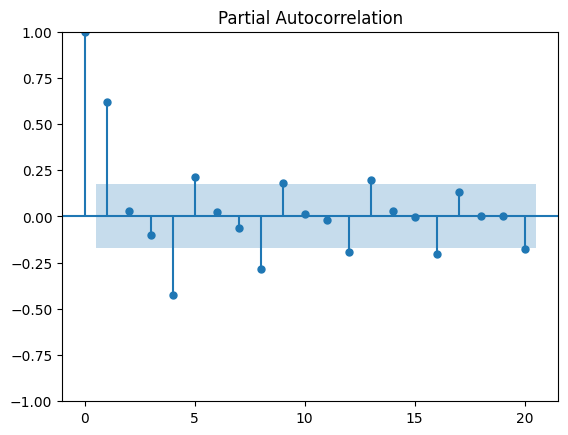

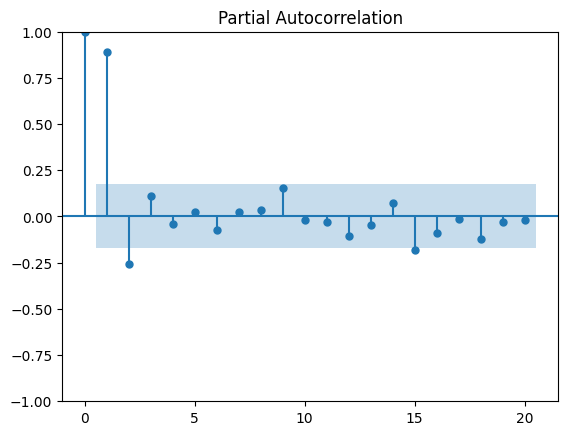

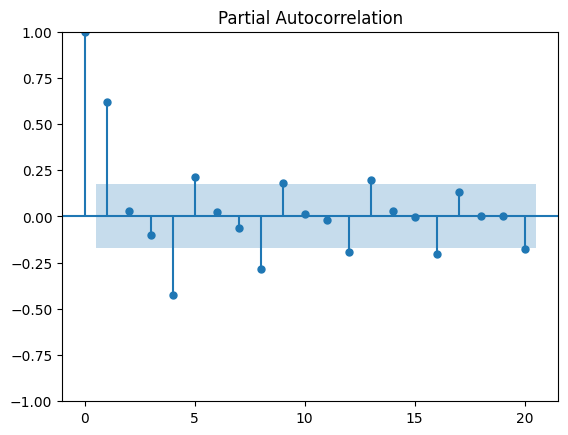

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF of the time series
plot_pacf(ciss, lags=20)
plot_pacf(rgdp_an, lags=20)

In [74]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.0077, 0.7821, -0.0271, 1])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [75]:
M=1000
initial_params = 0.0077, 0.7821, -0.0271, 1, 0.0077, 0.7821, -0.0271, 1
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.14838298464622607]
OLS beta_hat:  [-0.03524024167890109]
OLS gamma_hat:  [-0.6125841528685614]
OLS theta_hat:  [0.9999999999999947]
GLS alpha_hat:  [0.14804702644683873]
GLS beta_hat:  [-0.030899676187180737]
GLS gamma_hat:  [-0.611625585723887]
GLS theta_hat:  [1.0000000000002274]
OLS_bias_param_0 = -0.1407
OLS_bias_param_1 = 0.8173
OLS_bias_param_2 = 0.5855
OLS_bias_param_3 = 0.0000
OLS_RMSE = 0.5076
GLS_bias_param_0 = -0.1403
GLS_bias_param_1 = 0.8130
GLS_bias_param_2 = 0.5845
GLS_bias_param_3 = -0.0000
GLS_RMSE = 0.5056


In [71]:
def Laplace_estimation(df, p, M):

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['GDPgrowth(annualized)'].values
    T = min(M, len(y_dataset))
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.0077, 0.7821, -0.0271], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.0077, 0.7821, -0.0271])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix

result_matrix = Laplace_estimation(df, 0.5, 100)


Beta Matrix:
[[ 0.0077      0.7821     -0.028455  ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.00693     0.821205   -0.028455  ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.008085    0.821205   -0.02619667]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.028455  ]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.028455  ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.00795667  0.80817    -0.02800333]
 [ 0.008085    0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.821205   -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.0077      0.7821     -0.0271    ]
 [ 0.007315    0.80817    -0.02800333]
 [ 0.00795667  0.80817    -0.02800333]
 [ 0.00780694  0.77666875 -0.02687417]
 [ 0.0077   

In [84]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y_dataset = df['GDPgrowth(annualized)'].values
    #T = min(M, len(y_dataset))
    T = len(y_dataset)
    y = df['GDPgrowth(annualized)'].values[:T]
    x = df['CISS'].values[:T]  # extract data
    y = np.array(y)
    x = np.array(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values



In [85]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 50 # Number of iterations
sigma_ini = 1.55
β = np.array([0.16649059, 0.74366533, 0.29377513]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-1131.73687083   301.62078265 -3910.78423715]

RMSE:
2357.201573271658

Mean of RMSE:
2357.201573271658
Iteration 2: [ 9.17188361e-06  1.03170528e-03 -6.51634059e-05]

RMSE:
0.3555983656246723

Mean of RMSE:
0.3555983656246723
Iteration 3: [  7.47317006 837.17675143 -52.90670168]

RMSE:
484.1461320989841

Mean of RMSE:
484.1461320989841
Iteration 4: [ 0.00680058  0.77139001 -0.04859262]

RMSE:
0.40457854317974185

Mean of RMSE:
0.40457854317974185
Iteration 5: [ 0.00964796  1.11465137 -0.06993382]

RMSE:
0.5551339661173793

Mean of RMSE:
0.5551339661173793
Iteration 6: [ 0.00807187  0.92535636 -0.05827324]

RMSE:
0.46772807491769935

Mean of RMSE:
0.46772807491769935
Iteration 7: [ 0.00776782  0.93001964 -0.05780251]

RMSE:
0.46963864413055423

Mean of RMSE:
0.46963864413055423
Iteration 8: [ 0.00841826  0.92760701 -0.0587734 ]

RMSE:
0.46873779766762963

Mean of RMSE:
0.46873779766762963
Iteration 9: [ 0.00814022  0.93152283 -0.05829639]

RMSE:
0.47032674219825416

Mean 

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.13173687e+03,  3.01620783e+02, -3.91078424e+03],
       [ 9.17188361e-06,  1.03170528e-03, -6.51634059e-05],
       [ 7.47317006e+00,  8.37176751e+02, -5.29067017e+01],
       [ 6.80057701e-03,  7.71390011e-01, -4.85926186e-02],
       [ 9.64796096e-03,  1.11465137e+00, -6.99338170e-02],
       [ 8.07187222e-03,  9.25356358e-01, -5.82732419e-02],
       [ 7.76782264e-03,  9.30019641e-01, -5.78025126e-02],
       [ 8.41825927e-03,  9.27607013e-01, -5.87734006e-02],
       [ 8.14022047e-03,  9.31522826e-01, -5.82963855e-02],
       [ 7.87901403e-03,  9.37870177e-01, -5.77672691e-02],
       [ 9.33993633e-03,  9.02684607e-01, -6.07163624e-02],
       [ 7.09537647e-03,  9.55930188e-01, -5.62067723e-02],
       [ 7.40417642e-03,  9.49591510e-01, -5.68056689e-02],
       [ 7.22116290e-03,  9.52344037e-01, -5.64636120e-02],
       [ 7.14375139e-03,  9.52207305e-01, -5.63372889e-02],
       [ 7.13957169e-03,  9.51511427e-01

Forecasting

In [141]:
# Split the data into features (a) and target (b))
a = df.drop(['GDPgrowth(annualized)'], axis=1)  # Exclude the target column
b = df['GDPgrowth(annualized)']  # Target column

# Split the data into training set and test set
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.3, random_state=42)

df_train = pd.concat([a_train, b_train], axis=1)
df_test = pd.concat([a_test, b_test], axis=1)
print('a_train shape:', a_train.shape)
print('b_test shape:', b_test.shape)
print('a_train shape:', a_train.shape)
print('b_test shape:', b_test.shape)

a_train shape: (89, 4)
b_test shape: (39,)
a_train shape: (89, 4)
b_test shape: (39,)


In [132]:
def calculate_forecast(beta, y_test, x_test):
    y_test_lag = np.roll(y_test, 1)
    y_test_lag[0] = 0
    X_for = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
    y_for = X_for @ beta_lap

    diff = y_for - y_test

    # Create a DataFrame to compare y_for and y_test
    df_comparison = pd.DataFrame({'y_for': y_for, 'y_test': y_test, 'difference': diff})

    # Calculate the root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_for))

    return df_comparison, rmse

y_test = df_test['GDPgrowth(annualized)'].values
x_test = df_test['CISS'].values


In [135]:
beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
df_comparison, rmse = calculate_forecast(beta_lap, y_test, x_test)
print(df_comparison)
print('RMSE:', rmse)

      y_for    y_test  difference
0  0.006174  0.017373   -0.011199
1  0.016750  0.031432   -0.014682
2  0.031411  0.017098    0.014313
3  0.016613  0.018058   -0.001445
4  0.017785  0.018665   -0.000879
5  0.020622  0.014401    0.006221
6  0.007087  0.011357   -0.004270
RMSE: 0.009301648817334468


In [139]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def calculate_forecast(beta, y_test, x_test):
    y_test_lag = np.roll(y_test, 1)
    y_test_lag[0] = 0
    X_for = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
    y_for = X_for @ beta

    diff = y_for - y_test

    # Calculate the Mean Squared Forecast Error (MSFE)
    msfe = np.mean(diff ** 2)

    return diff, msfe

# Usage example
beta = np.array([0.00774911, 0.79202651, -0.02741974])
y_test = df_test['GDPgrowth(annualized)'].values
x_test = df_test['CISS'].values

diff, msfe = calculate_forecast(beta, y_test, x_test)

# Create a DataFrame to compare y_for and y_test
df_comparison = pd.DataFrame({'y_for': y_for, 'y_test': y_test, 'difference': diff})

# Print the DataFrame
print(df_comparison)

# Print the Mean Squared Forecast Error (MSFE)
print('MSFE:', msfe)


      y_for    y_test  difference
0  0.006174  0.017373   -0.011199
1  0.002990  0.031432   -0.014682
2  0.006516  0.017098    0.014313
3  0.016831  0.018058   -0.001445
4  0.028378  0.018665   -0.000879
5  0.019381  0.014401    0.006221
6  0.009983  0.011357   -0.004270
MSFE: 8.652067072101972e-05


In [136]:

def calculate_forecasts3(beta, y_test, x_test):
    forecasts = {}

    for lead_time in [1, 2, 3]:
        y_test_lag = np.roll(y_test, lead_time)
        y_test_lag[:lead_time] = 0
        X_for = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_for = X_for @ beta_lap

        # Calculate the difference between y_for and y_test
        diff = y_for - y_test

        # Create a DataFrame to compare y_for and y_test
        df_comparison = pd.DataFrame({'y_for': y_for, 'y_test': y_test, 'difference': diff})

        # Calculate the root mean squared error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_for))

        forecasts[lead_time] = {'df_comparison': df_comparison, 'rmse': rmse}

    return forecasts

# Usage example
beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
y_test = df_test['GDPgrowth(annualized)'].values
x_test = df_test['CISS'].values

forecasts = calculate_forecasts3(beta_lap, y_test, x_test)

# Print the results for different lead times
for lead_time, forecast_data in forecasts.items():
    print(f"Lead Time: {lead_time} year(s)")
    print(forecast_data['df_comparison'])
    print("RMSE:", forecast_data['rmse'])
    print()


Lead Time: 1 year(s)
      y_for    y_test  difference
0  0.006174  0.017373   -0.011199
1  0.016750  0.031432   -0.014682
2  0.031411  0.017098    0.014313
3  0.016613  0.018058   -0.001445
4  0.017785  0.018665   -0.000879
5  0.020622  0.014401    0.006221
6  0.007087  0.011357   -0.004270
RMSE: 0.009301648817334468

Lead Time: 2 year(s)
      y_for    y_test  difference
0  0.006174  0.017373   -0.011199
1  0.002990  0.031432   -0.028442
2  0.020276  0.017098    0.003178
3  0.027966  0.018058    0.009907
4  0.017025  0.018665   -0.001640
5  0.020142  0.014401    0.005741
6  0.010464  0.011357   -0.000893
RMSE: 0.01241583593749217

Lead Time: 3 year(s)
      y_for    y_test  difference
0  0.006174  0.017373   -0.011199
1  0.002990  0.031432   -0.028442
2  0.006516  0.017098   -0.010582
3  0.016831  0.018058   -0.001227
4  0.028378  0.018665    0.009713
5  0.019381  0.014401    0.004980
6  0.009983  0.011357   -0.001374
RMSE: 0.012922207548513882



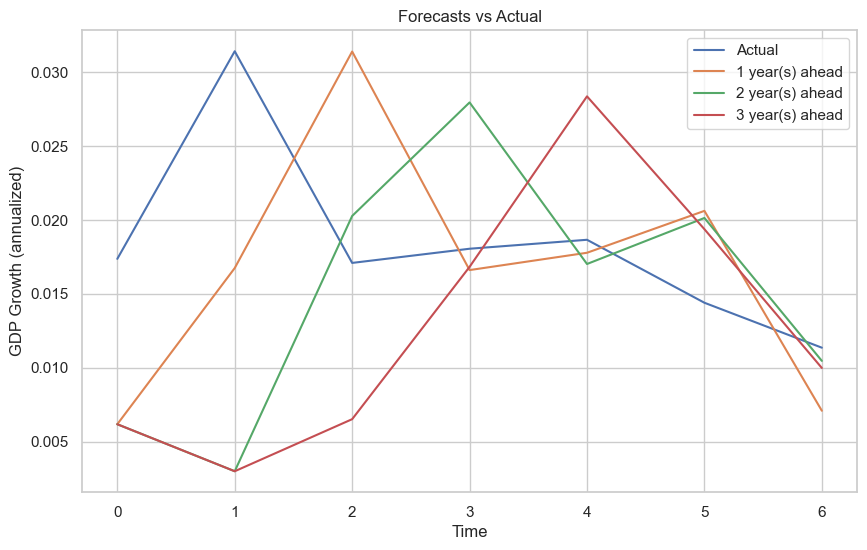

In [137]:
def calculate_forecasts2(beta_lap, y_test, x_test):
    forecasts = {}

    for lead_time in [1, 2, 3]:
        y_test_lag = np.roll(y_test, lead_time)
        y_test_lag[:lead_time] = 0
        X_for = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_for = X_for @ beta_lap

        # Calculate the difference between y_for and y_test
        diff = y_for - y_test

        # Create a DataFrame to compare y_for and y_test
        df_comparison = pd.DataFrame({'y_for': y_for, 'y_test': y_test, 'difference': diff})

        # Calculate the root mean squared error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_for))

        forecasts[lead_time] = {'y_for': y_for, 'df_comparison': df_comparison, 'rmse': rmse}

    return forecasts

# Usage example
beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
y_test = df_test['GDPgrowth(annualized)'].values
x_test = df_test['CISS'].values

forecasts = calculate_forecasts2(beta_lap, y_test, x_test)

# Plotting the forecasts
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')

for lead_time, forecast_data in forecasts.items():
    y_for = forecast_data['y_for']
    label = f"{lead_time} year(s) ahead"
    plt.plot(y_for, label=label)

plt.xlabel('Time')
plt.ylabel('GDP Growth (annualized)')
plt.title('Forecasts vs Actual')
plt.legend()
plt.show()


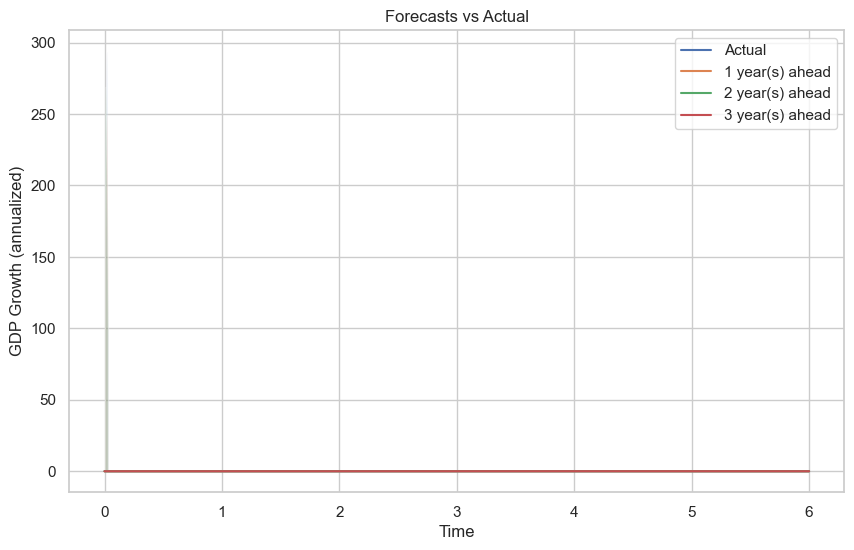

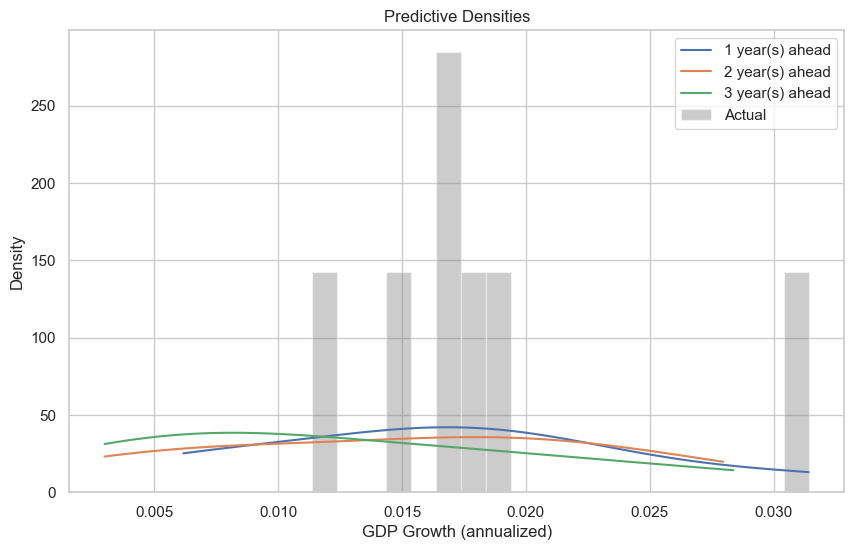

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde

def calculate_forecasts5(beta_lap, y_test, x_test):
    forecasts = {}

    for lead_time in [1, 2, 3]:
        y_test_lag = np.roll(y_test, lead_time)
        y_test_lag[:lead_time] = 0
        X_for = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_for = X_for @ beta_lap

        # Calculate the difference between y_for and y_test
        diff = y_for - y_test

        # Create a DataFrame to compare y_for and y_test
        df_comparison = pd.DataFrame({'y_for': y_for, 'y_test': y_test, 'difference': diff})

        # Calculate the root mean squared error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_for))

        # Estimate the density of the forecasted values
        density = gaussian_kde(y_for)

        forecasts[lead_time] = {'y_for': y_for, 'df_comparison': df_comparison, 'rmse': rmse, 'density': density}

    return forecasts

# Usage example
beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
y_test = df_test['GDPgrowth(annualized)'].values
x_test = df_test['CISS'].values

forecasts = calculate_forecasts5(beta_lap, y_test, x_test)

# Plotting the forecasts
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')

for lead_time, forecast_data in forecasts.items():
    y_for = forecast_data['y_for']
    label = f"{lead_time} year(s) ahead"
    plt.plot(y_for, label=label)

    # Plot the density
    density = forecast_data['density']
    x_vals = np.linspace(min(y_for), max(y_for), 100)
    y_vals = density(x_vals) * len(y_for)  # Scale the density to match the data
    plt.fill_between(x_vals, 0, y_vals, alpha=0.2)

plt.xlabel('Time')
plt.ylabel('GDP Growth (annualized)')
plt.title('Forecasts vs Actual')
plt.legend()
plt.show()

# Plotting the densities
plt.figure(figsize=(10, 6))

for lead_time, forecast_data in forecasts.items():
    density = forecast_data['density']
    y_for = forecast_data['y_for']
    x_vals = np.linspace(min(y_for), max(y_for), 100)
    y_vals = density(x_vals)
    plt.plot(x_vals, y_vals, label=f"{lead_time} year(s) ahead")

# Plot the histogram of actual values
plt.hist(y_test, bins=20, density=True, alpha=0.4, color='gray', label='Actual')

plt.xlabel('GDP Growth (annualized)')
plt.ylabel('Density')
plt.title('Predictive Densities')
plt.legend()
plt.show()


In [180]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    
    return mse_list


# Usage example
df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

for horizon in horizons:
    mse_list = recursive_poos(df_complete, horizon, beta_lap)
    avg_mse = np.mean(mse_list)
    print(f"Average MSE for horizon {horizon}: {avg_mse}")


Average MSE for horizon 1: 0.0011139697285139102
Average MSE for horizon 2: 0.0011195670635388794
Average MSE for horizon 3: 0.0011258108459036725
Average MSE for horizon 4: 0.0011298776185967373
Average MSE for horizon 5: 0.0011337497767893844
Average MSE for horizon 6: 0.0011399451012437012
Average MSE for horizon 7: 0.0011474594187636214
Average MSE for horizon 8: 0.0011313296533233624


Average MSE for horizon 1: 0.0011139697285139102


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

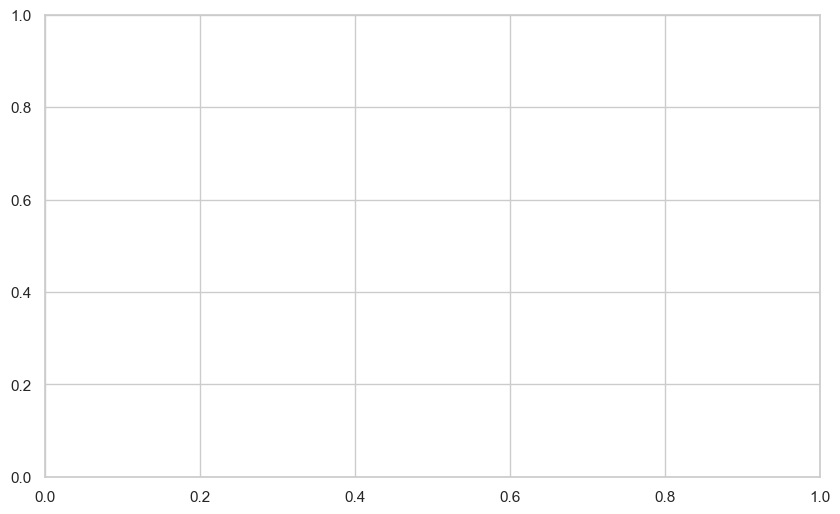

In [181]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
    

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

    return mse_list



horizon = 1
mse_list = recursive_poos(df_complete, horizon, beta_lap)
avg_mse = np.mean(mse_list)
print(f"Average MSE for horizon {horizon}: {avg_mse}")

if horizon == 1:
    # Plot predictive density against the real values
    fig, ax = plt.subplots(figsize=(10, 6))
    for vintage in df_complete['TIME'].unique()[:-horizon]:
        df_estimation = df_complete[df_complete['TIME'] <= vintage]
        df_test = df_complete[df_complete['TIME'] > vintage]
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values
        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        sns.kdeplot(y_test, label='Real Values', alpha=0.5)
        sns.kdeplot(y_forecast, label='Predictive Density', alpha=0.5)

    ax.set_xlabel('GDP Growth')
    ax.set_ylabel('Density')
    ax.set_title('Predictive Density vs. Real Values (Horizon 1)')
    plt.legend()
    plt.show()


In [163]:
beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])
betas = [beta_lap, beta_em, beta_ols, beta_gls]
horizon = 1
for beta in betas:
    mse_list = recursive_poos(df_complete, horizon, beta)
    avg_mse = np.mean(mse_list)
    print(f"Average MSE for horizon {horizon}: {avg_mse}")


Average MSE for horizon 1: 0.0011139697285139102
Average MSE for horizon 1: 0.0012810884368658253
Average MSE for horizon 1: 0.008083100651312309
Average MSE for horizon 1: 0.008053194712855028


Average MSE for horizon 1: 0.0011139697285139102


/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_42803/3884688202.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  df_test = df_complete[df_complete['TIME'] > pd.Timestamp(df_complete.index[-horizon-1]).to_pydatetime()]


Average MSE for horizon 1: 0.0012810884368658253


/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_42803/3884688202.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  df_test = df_complete[df_complete['TIME'] > pd.Timestamp(df_complete.index[-horizon-1]).to_pydatetime()]


Average MSE for horizon 1: 0.008083100651312309


/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_42803/3884688202.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  df_test = df_complete[df_complete['TIME'] > pd.Timestamp(df_complete.index[-horizon-1]).to_pydatetime()]


Average MSE for horizon 1: 0.008053194712855028


/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_42803/3884688202.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  df_test = df_complete[df_complete['TIME'] > pd.Timestamp(df_complete.index[-horizon-1]).to_pydatetime()]


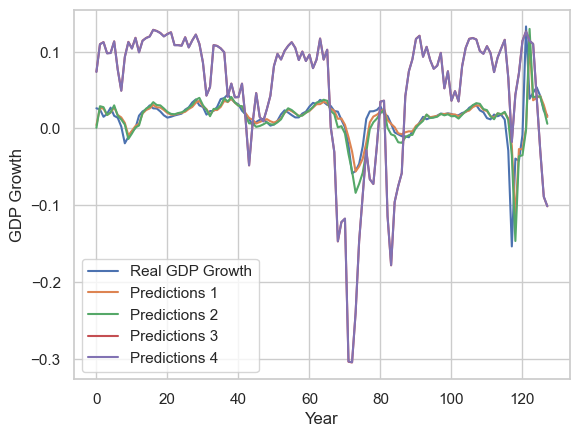

In [174]:
horizon = 1
predictions = []
for beta in betas:
    mse_list = recursive_poos(df_complete, horizon, beta)
    avg_mse = np.mean(mse_list)
    print(f"Average MSE for horizon {horizon}: {avg_mse}")
    
    # Generate forecast for horizon 1
    df_complete['TIME'] = pd.to_datetime(df_complete['TIME'])
    df_estimation = df_complete[df_complete['TIME'] <= pd.Timestamp(df_complete.index[-horizon-1])]
    df_test = df_complete[df_complete['TIME'] > pd.Timestamp(df_complete.index[-horizon-1]).to_pydatetime()]
    y_estimation = df_estimation['GDPgrowth(annualized)'].values
    x_estimation = df_estimation['CISS'].values
    y_test = df_test['GDPgrowth(annualized)'].values
    x_test = df_test['CISS'].values
    y_estimation_lag = np.roll(y_estimation, 1)
    y_estimation_lag = np.roll(y_estimation, 1)
    if len(y_estimation_lag) > 0:
        y_estimation_lag[0] = 0
    X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
    y_test_lag = np.roll(y_test, 1)
    y_test_lag[0] = 0
    X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
    y_forecast = X_test @ beta
    predictions.append(y_forecast)

# Plot results
plt.plot(df_test.index, df_test['GDPgrowth(annualized)'], label='Real GDP Growth')
for i, y_forecast in enumerate(predictions):
    plt.plot(df_test.index, y_forecast, label=f'Predictions {i+1}')
plt.xlabel('Year')
plt.ylabel('GDP Growth')
plt.legend()
plt.show()

